In [14]:
# Notebook to read in an image, display its bounding boxes, display its predicted masks
# +/- an overlay, on a bad image from vesicles_240 and a good image from vesicles_240.
import pandas as pd
from vesicle_picker import funcs_mrcio, preprocess, generate_masks, postprocess, helpers
import matplotlib.pyplot as plt
import numpy as np
import copy
from tqdm import tqdm, trange
from cryosparc.tools import downsample
import datetime
import time
from skimage.filters import gaussian

In [3]:
# Read in the file
manual_picks = pd.read_csv('~/vesicle-picker-dev/vesicles_240/bounding_boxes/first_50_pass2.csv')

# Find the centers
manual_picks['x_center'] = manual_picks['x'] + manual_picks['width']/2
manual_picks['y_center'] = manual_picks['y'] + manual_picks['height']/2

# Compute the area
manual_picks['area'] = manual_picks['width'] + manual_picks['height']

# Extract the UIDs
manual_picks['uid'] = manual_picks['file_name'].apply(lambda x: x.split("/")[-1][:-4])

In [4]:
manual_picks

,file_id,file_name,x,y,width,height,x_center,y_center,area,uid
0,0,/Users/rkarimi/vesicle-picker/vesicles_240/low...,147.456,57.344,73.728,77.824,184.320,96.256,151.552,10052325399042271146
1,0,/Users/rkarimi/vesicle-picker/vesicles_240/low...,278.528,114.688,94.208,86.016,325.632,157.696,180.224,10052325399042271146
2,0,/Users/rkarimi/vesicle-picker/vesicles_240/low...,147.456,172.032,110.592,98.304,202.752,221.184,208.896,10052325399042271146
3,0,/Users/rkarimi/vesicle-picker/vesicles_240/low...,40.960,172.032,81.920,77.824,81.920,210.944,159.744,10052325399042271146
4,0,/Users/rkarimi/vesicle-picker/vesicles_240/low...,0.000,274.432,65.536,114.688,32.768,331.776,180.224,10052325399042271146
...,...,...,...,...,...,...,...,...,...,...
1999,51,/Users/rkarimi/vesicle-picker/vesicles_240/low...,544.768,319.488,61.440,77.824,575.488,358.400,139.264,13561974487692598017
2000,51,/Users/rkarimi/vesicle-picker/vesicles_240/low...,69.632,958.464,57.344,53.248,98.304,985.088,110.592,13561974487692598017
2001,51,/Users/rkarimi/vesicle-picker/vesicles_240/low...,143.360,970.752,49.152,45.056,167.936,993.280,94.208,13561974487692598017
2002,51,/Users/rkarimi/vesicle-picker/vesicles_240/low...,118.784,208.896,90.112,106.496,163.840,262.144,196.608,13561974487692598017


In [ ]:
# Find an example good and bad image from the roundness_area dataset
# The one with the highest F1 score: UID 13212947283733073798
# The one with the lowest F1 score: UID 12476944800991995114

In [7]:
# Start by processing the good one and getting its masks
model = generate_masks.initialize_model(model_weights_path = "./sam_vit_h_4b8939.pth", model_type='vit_h', device='cuda:0')

In [6]:
# Define run parameters
downsample_factor = 4
lowpass_mode = 'bilateral'
d = 20
sigmaColor = 70
sigmaSpace = 70
pred_iou_thresh = 0.9
stability_score_thresh = 0.9
psize=1.03

In [5]:
# Define an MRC import function
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename,'rb')
    
    # Use funcs_mrcio to extract image array and rescale values to lie between [-1, 1]
    image = funcs_mrcio.irdsec_opened(micrograph,0)
    
    # Use funcs_mrcio to extract header info
    header = funcs_mrcio.irdhdr_opened(micrograph)
    
    # Return the rescaled image and header
    return image, header

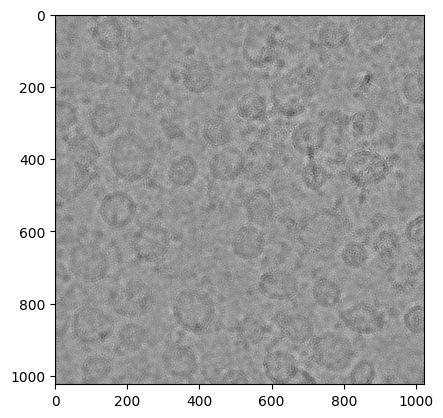

In [56]:
# Import the image
image_fullres, header = import_mrc("/home/rk/vesicle-picker-dev/vesicles_240/raw_mrc/12758756789755284571.mrc")

# Use the preprocess module to get micrograph ready for segmentation
preprocessed_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample=downsample_factor, 
                                                           lowpass_mode=lowpass_mode,
                                                           d=d,
                                                           sigmaColor=sigmaColor,
                                                           sigmaSpace=sigmaSpace)

plt.imshow(preprocessed_micrograph, cmap="Greys_r")

In [57]:
masks = generate_masks.generate_masks(preprocessed_micrograph, model, 
                                      points_per_side=36,
                                      points_per_batch=32,
                                      pred_iou_thresh=pred_iou_thresh,
                                      stability_score_thresh=stability_score_thresh,
                                      crop_n_layers=1,
                                      crop_n_points_downscale_factor=2,
                                      crop_nms_thresh=0.1,
                                      min_mask_region_area=100,
                                      psize=1.03,
                                      downsample=downsample_factor)

In [58]:
# Use the postprocess module to compute statistics on the vesicles
postprocessed_masks = postprocess.postprocess_masks(masks, 
                              [postprocess.find_mask_intensity, postprocess.find_contour, postprocess.find_roundness, postprocess.fit_ellipse], 
                              preprocessed_micrograph)

# Filter these vesicles based on min and max values recorded in 'filters.ini'
filtered_masks = postprocess.apply_filters(postprocessed_masks, "tests/filters_240.ini")

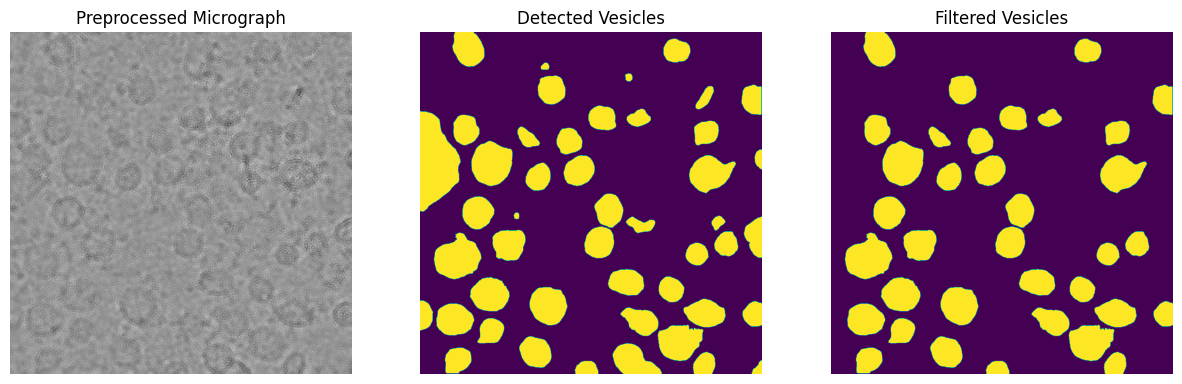

In [59]:
# Make sure they look good
# Create a figure with three subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image in the first subplot
axes[0].imshow(preprocessed_micrograph, cmap="Greys_r")
axes[0].set_title('Preprocessed Micrograph')

# Plot the second image in the second subplot
axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
axes[1].set_title('Detected Vesicles')

# # Plot the third image in the third subplot
axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
axes[2].set_title('Filtered Vesicles')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

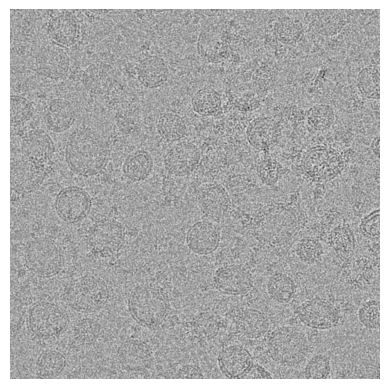

In [60]:
# Make a display micrograph
display_micrograph = downsample(gaussian(image_fullres,3), 4)
plt.imshow(display_micrograph, cmap="Greys_r")
plt.axis('off')

plt.savefig("bbox_comparison/12758756789755284571_raw.png", dpi=600, bbox_inches="tight", pad_inches=0)


plt.show()

In [61]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.4]])
        img[m] = color_mask
    ax.imshow(img)

In [62]:
import matplotlib.patches as patches

def draw_bounding_boxes_on_existing_plot(df, ax):
    # Ensure the DataFrame has the required columns
    required_columns = {'x', 'y', 'width', 'height'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"DataFrame must contain the columns: {required_columns}")

    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        # Extract bounding box parameters
        x, y, width, height = row['x'], row['y'], row['width'], row['height']

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')

        # Add the rectangle to the existing plot
        ax.add_patch(rect)

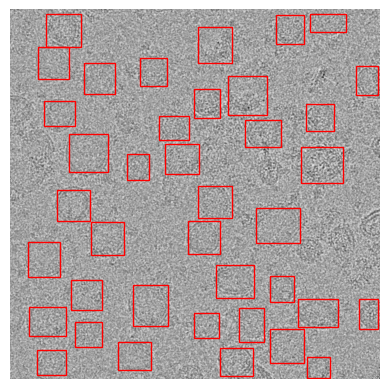

In [64]:
# Overlay the filtered masks on the vesicles
plt.imshow(display_micrograph, cmap="Greys_r")
#show_anns(filtered_masks)
# Get the current axis
ax = plt.gca()
# Draw the bounding boxes on the existing plot
draw_bounding_boxes_on_existing_plot(manual_picks[manual_picks['uid']=='12758756789755284571'], ax)
plt.axis('off')
plt.savefig("bbox_comparison/12758756789755284571_manual.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

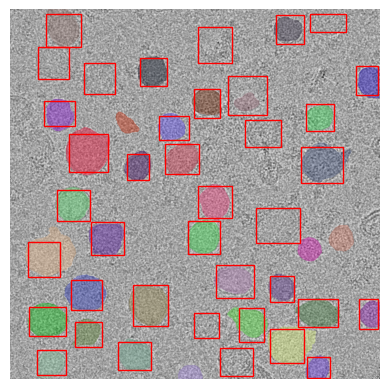

In [65]:
# Overlay the filtered masks on the vesicles
plt.imshow(display_micrograph, cmap="Greys_r")
show_anns(filtered_masks)
plt.axis('off')
plt.savefig("bbox_comparison/12758756789755284571_sa.png", dpi=600, bbox_inches="tight", pad_inches=0)
# Get the current axis
ax = plt.gca()
# Draw the bounding boxes on the existing plot
draw_bounding_boxes_on_existing_plot(manual_picks[manual_picks['uid']=='12758756789755284571'], ax)
plt.savefig("bbox_comparison/12758756789755284571_overlay.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()